Loading data...
Preprocessing data...
Running simple basket analysis...
Analyzing profitability...
Analyzing sales patterns by time...
Creating transaction matrix...
Running market basket analysis...
Finding frequent itemsets...
Generating association rules...
Visualizing association rules...


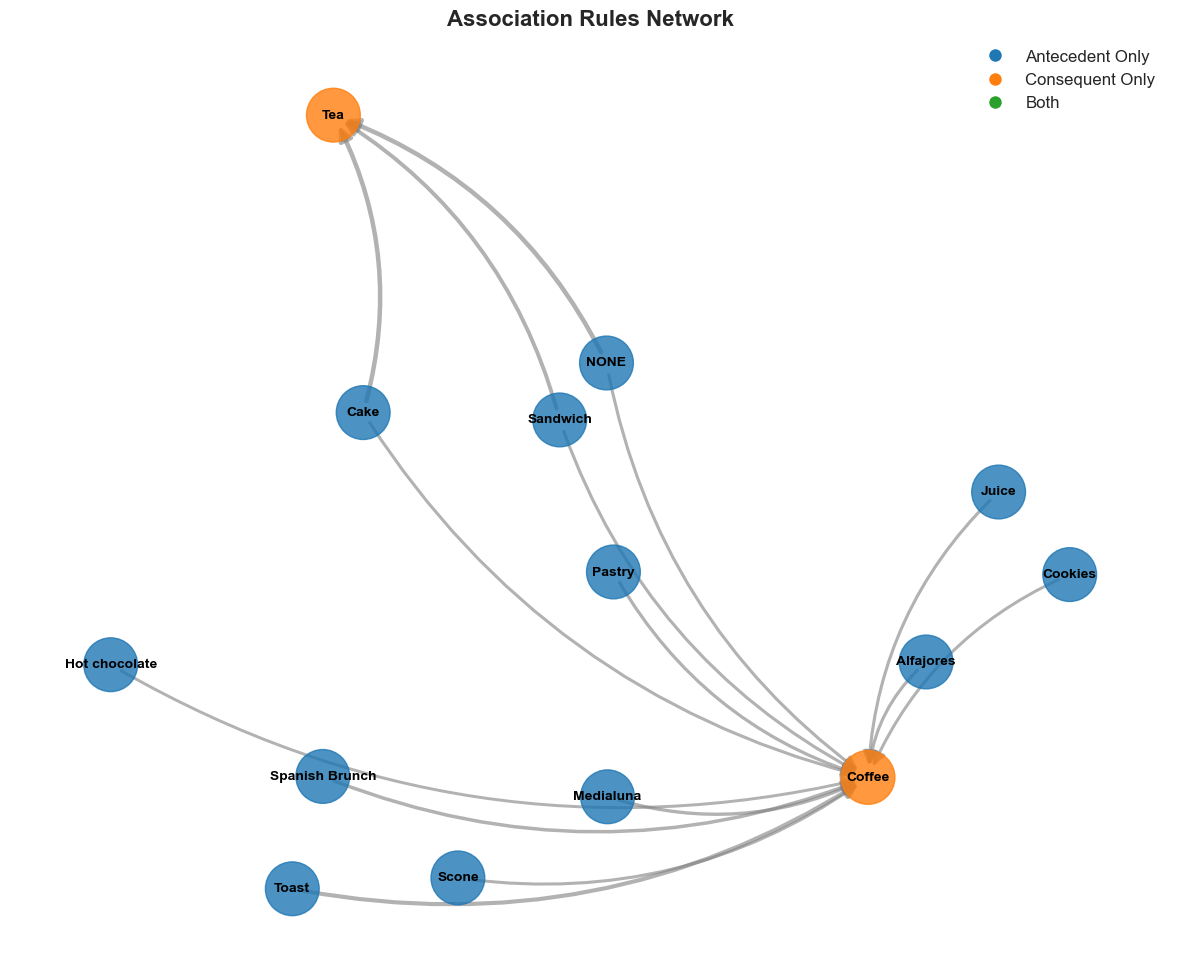

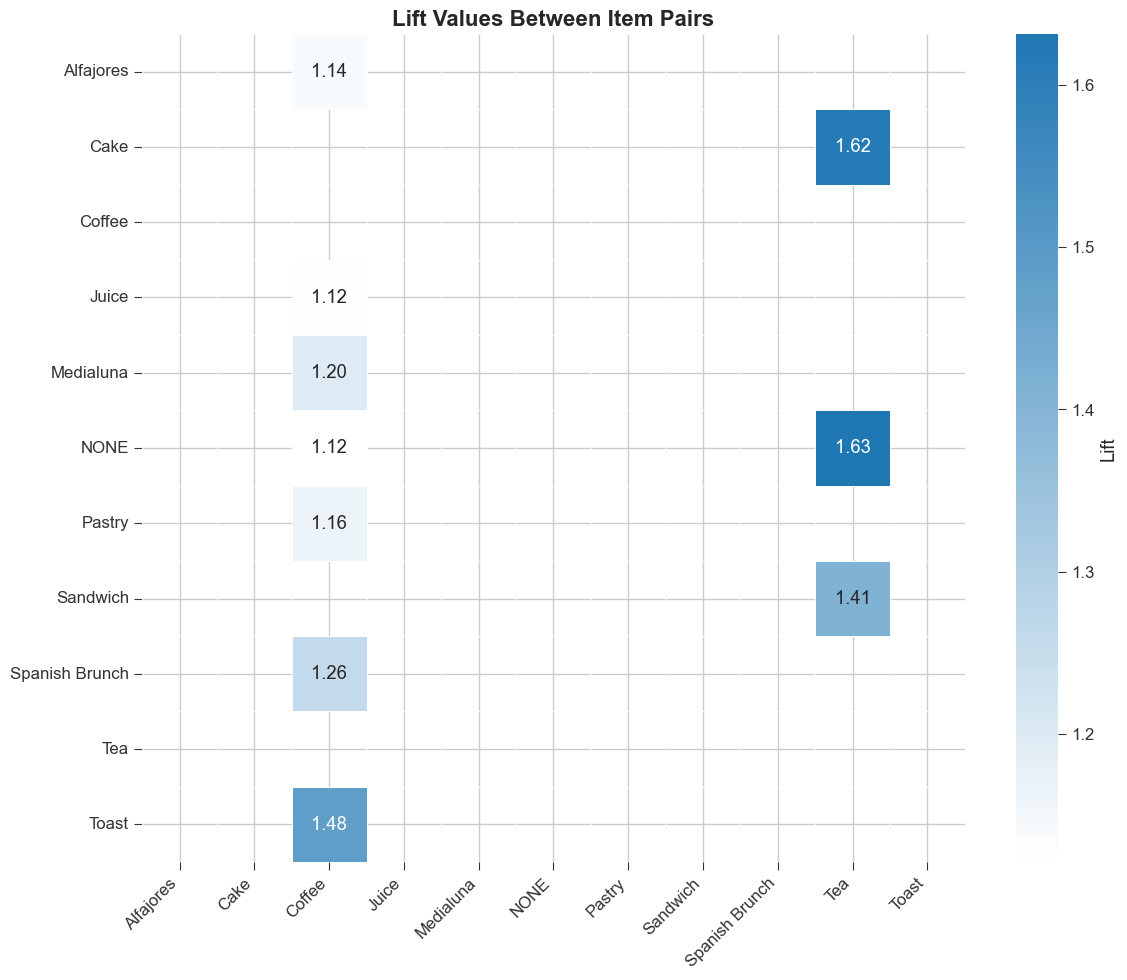

Creating dashboard visualizations...


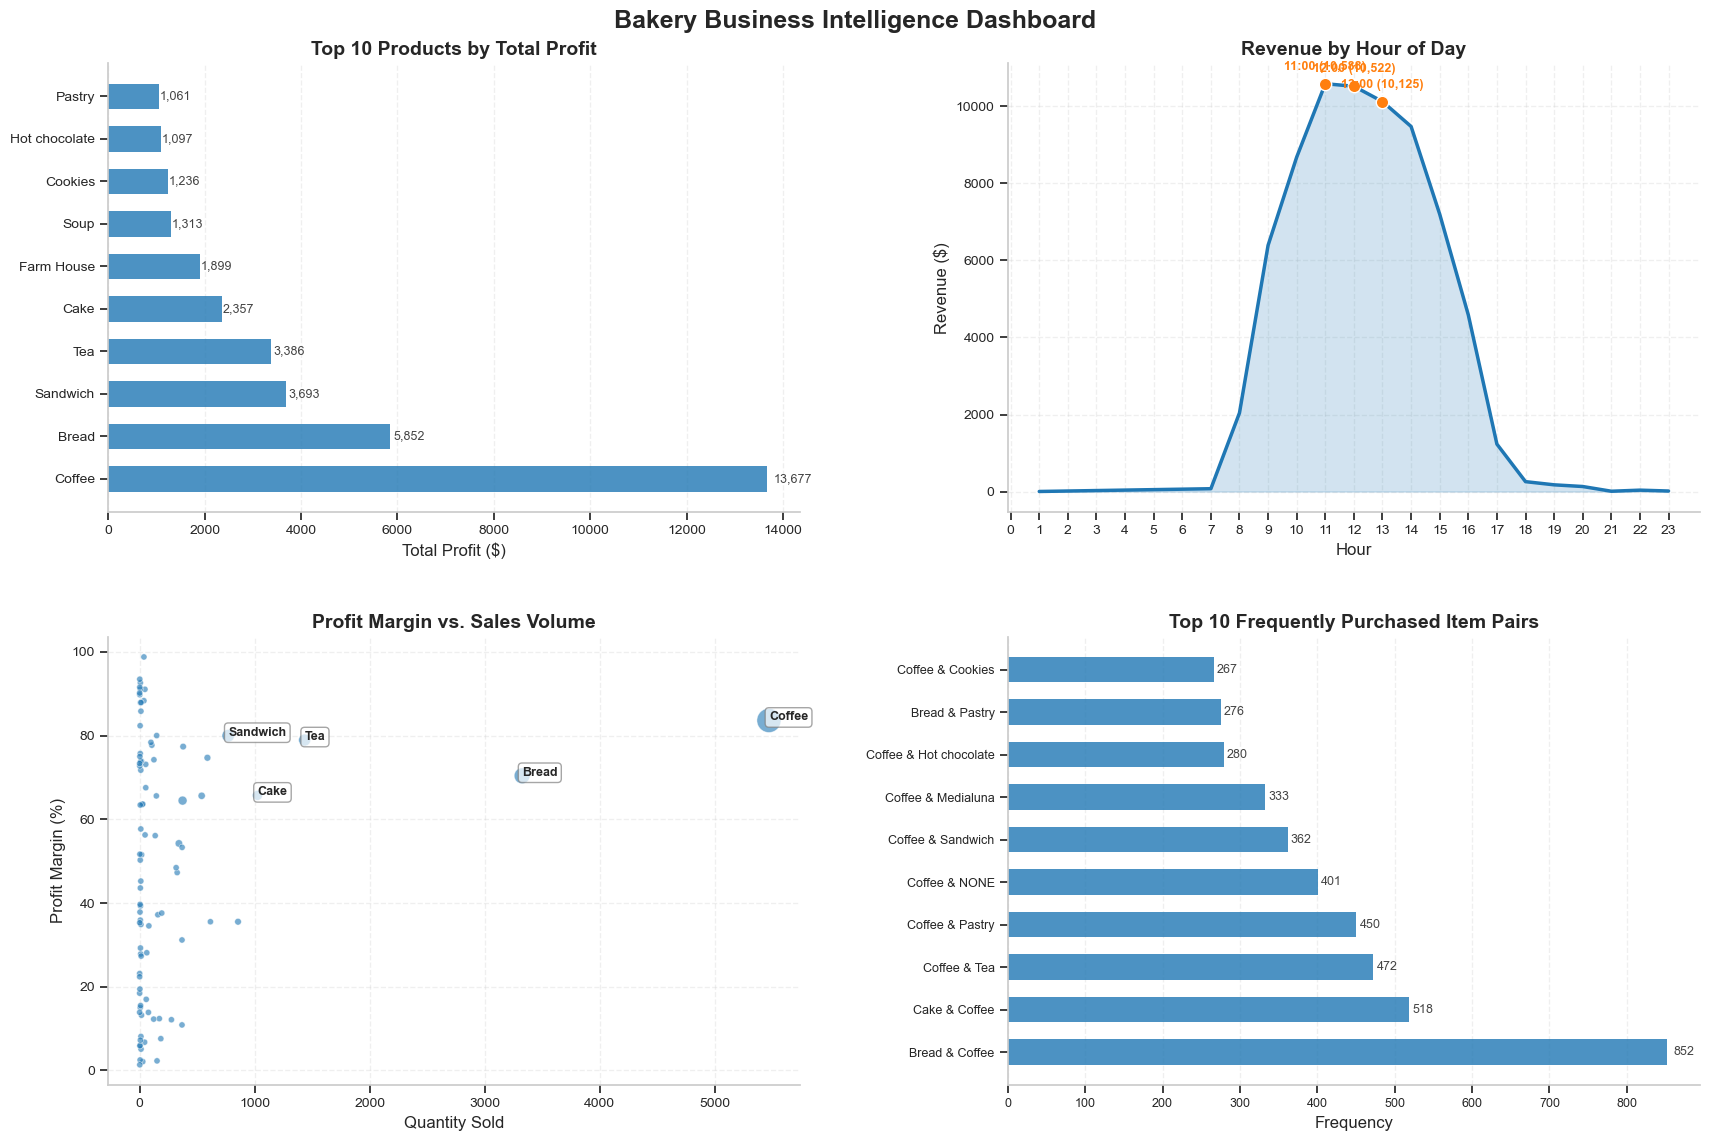


KEY FINDINGS:

Top 5 Most Profitable Products:
          Total Profit  Profit Margin  Quantity Sold
Item                                                
Coffee        13677.50      83.612040           5471
Bread          5852.00      70.400000           3325
Sandwich       3693.09      79.966611            771
Tea            3386.60      78.929766           1435
Cake           2357.50      65.714286           1025

Top 5 Item Pairs:
     Item1   Item2  Frequency
4    Bread  Coffee        852
97    Cake  Coffee        518
12  Coffee     Tea        472
3   Coffee  Pastry        450
36  Coffee    NONE        401

Peak Sales Hours:
      Transaction Count   Revenue
Hour                             
11                 1445  10588.45
12                 1347  10522.42
13                 1163  10125.34

TOP ASSOCIATION RULES:

IF customer buys:              THEN likely to buy:            Support    Confidence Lift      
-------------------------------------------------------------------------

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx

# Set global plotting parameters for cleaner visualizations
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['axes.edgecolor'] = '#333333'
plt.rcParams['xtick.major.width'] = 0.8
plt.rcParams['ytick.major.width'] = 0.8
plt.rcParams['xtick.color'] = '#333333'
plt.rcParams['ytick.color'] = '#333333'

# Load data
def load_data(file_path):
    # Read both sheets
    transactions_df = pd.read_excel(file_path, sheet_name=0)
    costs_df = pd.read_excel(file_path, sheet_name=1)
    
    # Make sure Item names are consistent between the two sheets
    transactions_df['Item'] = transactions_df['Item'].str.strip()
    costs_df['Item'] = costs_df['Item'].str.strip()
    
    return transactions_df, costs_df

# Data Preprocessing
def preprocess_data(transactions_df, costs_df):
    # Convert date and time to datetime
    if 'Date' in transactions_df.columns and 'Time' in transactions_df.columns:
        transactions_df['DateTime'] = pd.to_datetime(
            transactions_df['Date'].astype(str) + ' ' + transactions_df['Time'].astype(str)
        )
        
        # Extract useful time components
        transactions_df['Hour'] = transactions_df['DateTime'].dt.hour
        transactions_df['DayOfWeek'] = transactions_df['DateTime'].dt.dayofweek
        transactions_df['Month'] = transactions_df['DateTime'].dt.month
        transactions_df['DayName'] = transactions_df['DateTime'].dt.day_name()
    
    # Add cost data to transactions
    merged_df = pd.merge(transactions_df, costs_df, on='Item', how='left')
    
    # Calculate profit for each transaction
    if 'Sale Price' in merged_df.columns and 'Our Cost' in merged_df.columns:
        merged_df['Profit'] = merged_df['Sale Price'] - merged_df['Our Cost']
        merged_df['Margin'] = (merged_df['Profit'] / merged_df['Sale Price']) * 100
    
    return merged_df

# Simple Basket Analysis
def simple_basket_analysis(transactions_df):
    # Look at item pairs within the same transaction
    all_item_pairs = []
    
    # Group by transaction
    transaction_groups = transactions_df.groupby('Transaction')
    
    # For each transaction, create all possible pairs of items
    for transaction_id, group in transaction_groups:
        items = group['Item'].unique()
        if len(items) > 1:  # Only consider transactions with at least 2 items
            for i in range(len(items)):
                for j in range(i+1, len(items)):
                    all_item_pairs.append((items[i], items[j]))
    
    # Count frequency of each pair
    pair_counts = {}
    for pair in all_item_pairs:
        # Sort pair to ensure consistent ordering
        sorted_pair = tuple(sorted(pair))
        if sorted_pair in pair_counts:
            pair_counts[sorted_pair] += 1
        else:
            pair_counts[sorted_pair] = 1
    
    # Convert to dataframe
    pairs_df = pd.DataFrame(list(pair_counts.items()), columns=['Pair', 'Frequency'])
    pairs_df['Item1'] = pairs_df['Pair'].apply(lambda x: x[0])
    pairs_df['Item2'] = pairs_df['Pair'].apply(lambda x: x[1])
    pairs_df = pairs_df.sort_values('Frequency', ascending=False)
    
    return pairs_df[['Item1', 'Item2', 'Frequency']]

# Profitability Analysis
def profitability_analysis(merged_df):
    # Analyze profitability by item
    profit_by_item = merged_df.groupby('Item').agg({
        'Sale Price': 'first',
        'Our Cost': 'first',
        'Transaction': 'count'
    }).rename(columns={'Transaction': 'Quantity Sold'})
    
    profit_by_item['Total Revenue'] = profit_by_item['Sale Price'] * profit_by_item['Quantity Sold']
    profit_by_item['Total Cost'] = profit_by_item['Our Cost'] * profit_by_item['Quantity Sold']
    profit_by_item['Total Profit'] = profit_by_item['Total Revenue'] - profit_by_item['Total Cost']
    profit_by_item['Profit Margin'] = (profit_by_item['Total Profit'] / profit_by_item['Total Revenue']) * 100
    
    return profit_by_item.sort_values('Total Profit', ascending=False)

# Time-Based Analysis
def time_analysis(merged_df):
    # Sales by hour of day
    hourly_sales = merged_df.groupby('Hour').agg({
        'Transaction': 'nunique',
        'Sale Price': 'sum'
    }).rename(columns={'Transaction': 'Transaction Count', 'Sale Price': 'Revenue'})
    
    # Sales by day of week
    daily_sales = merged_df.groupby('DayName').agg({
        'Transaction': 'nunique',
        'Sale Price': 'sum'
    }).rename(columns={'Transaction': 'Transaction Count', 'Sale Price': 'Revenue'})
    
    # Items sold by hour (top 5 items for each hour)
    items_by_hour = {}
    for hour in sorted(merged_df['Hour'].unique()):
        hour_data = merged_df[merged_df['Hour'] == hour]
        top_items = hour_data['Item'].value_counts().head(5)
        items_by_hour[hour] = top_items
    
    return hourly_sales, daily_sales, items_by_hour

# Visualizations 
def create_visualizations(merged_df, profit_by_item, hourly_sales, daily_sales, pairs_df):
    # Set clean, minimalist style
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_context("notebook", font_scale=1.1)
    
    # Create figure with improved layout
    fig = plt.figure(figsize=(18, 12))
    
    # Define a clean, simple color palette
    palette = sns.color_palette("Blues_d", 10)
    highlight_color = '#1f77b4'  # Main blue color
    accent_color = '#ff7f0e'     # Orange highlight
    
    # 1. Top Products by Total Profit - SIMPLIFIED
    ax1 = fig.add_subplot(2, 2, 1)
    top_profits = profit_by_item.head(10)
    
    # Use single color with slight opacity variation
    bars = ax1.barh(top_profits.index, top_profits['Total Profit'], 
                   color=highlight_color, alpha=0.8, height=0.6)
    
    # Simplified value labels - no $ signs, just clean numbers
    for i, bar in enumerate(bars):
        width = bar.get_width()
        label_x_pos = width * 1.01
        ax1.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{int(width):,}',
                 va='center', fontsize=9, color='#444444')
    
    ax1.set_title('Top 10 Products by Total Profit', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Total Profit ($)', fontsize=12)
    
    # Remove top and right spines for cleaner look
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.tick_params(axis='both', labelsize=10)
    
    # Reduce gridlines for less noise
    ax1.grid(axis='x', linestyle='--', alpha=0.3)
    ax1.grid(axis='y', visible=False)
    
    # 2. Hourly Sales Pattern - SIMPLIFIED
    ax2 = fig.add_subplot(2, 2, 2)
    
    # Simplified line with softer fill
    ax2.plot(hourly_sales.index, hourly_sales['Revenue'], 
             color=highlight_color, linewidth=2.5)
    
    # Lighter fill for less distraction
    ax2.fill_between(hourly_sales.index, hourly_sales['Revenue'], 
                    color=highlight_color, alpha=0.2)
    
    # Highlight only top 3 peak hours with simple markers 
    peak_hours = hourly_sales.nlargest(3, 'Revenue')
    ax2.scatter(peak_hours.index, peak_hours['Revenue'], color=accent_color, 
                s=80, zorder=3, edgecolors='white', linewidth=1)
    
    # Simpler annotations for peak hours - just the hour and value
    for idx, row in peak_hours.iterrows():
        ax2.annotate(f"{idx}:00 ({int(row['Revenue']):,})", 
                     (idx, row['Revenue']), 
                     xytext=(0, 10), textcoords='offset points',
                     fontsize=9, fontweight='bold', ha='center',
                     color=accent_color)
    
    ax2.set_title('Revenue by Hour of Day', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Hour', fontsize=12)
    ax2.set_ylabel('Revenue ($)', fontsize=12)
    ax2.set_xticks(range(0, 24))
    
    # Simplified grid and removed spines
    ax2.grid(True, linestyle='--', alpha=0.3)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.tick_params(axis='both', labelsize=10)
    
    # 3. Profit Margin vs. Volume - SIMPLIFIED
    ax3 = fig.add_subplot(2, 2, 3)
    
    # Simplified scatter - uniform size with opacity indicating profit
    sizes = np.clip(profit_by_item['Total Profit']/profit_by_item['Total Profit'].max() * 300, 20, 300)
    
    # Use simpler color scheme - all one color with opacity variation
    scatter = ax3.scatter(profit_by_item['Quantity Sold'], profit_by_item['Profit Margin'],
                         alpha=0.6, s=sizes, color=highlight_color, 
                         edgecolors='white', linewidth=0.5)
    
    # Only label key products (top 5)
    for idx, row in profit_by_item.head(5).iterrows():
        # Use simpler annotation with rectangle
        ax3.annotate(idx, 
                    (row['Quantity Sold'], row['Profit Margin']),
                    fontsize=9, fontweight='bold', 
                    bbox=dict(boxstyle="round,pad=0.3", fc='white', ec="gray", alpha=0.7))
    
    ax3.set_title('Profit Margin vs. Sales Volume', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Quantity Sold', fontsize=12)
    ax3.set_ylabel('Profit Margin (%)', fontsize=12)
    
    # Simplified grid and removed spines
    ax3.grid(True, linestyle='--', alpha=0.3)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.tick_params(axis='both', labelsize=10)
    
    # 4. Top Item Pairs - SIMPLIFIED
    ax4 = fig.add_subplot(2, 2, 4)
    top_pairs = pairs_df.head(10)
    
    # Create cleaner, more readable labels
    pair_labels = [f"{row['Item1']} & {row['Item2']}" for _, row in top_pairs.iterrows()]
    
    # Use a single color with slight variations
    bars = ax4.barh(pair_labels, top_pairs['Frequency'], 
                   color=highlight_color, alpha=0.8, height=0.6)
    
    # Simple value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        label_x_pos = width * 1.01
        ax4.text(label_x_pos, bar.get_y() + bar.get_height()/2, f'{int(width)}',
                 va='center', fontsize=9, color='#444444')
    
    ax4.set_title('Top 10 Frequently Purchased Item Pairs', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Frequency', fontsize=12)
    
    # Simplified grid and removed spines
    ax4.grid(axis='x', linestyle='--', alpha=0.3)
    ax4.grid(axis='y', visible=False)
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.tick_params(axis='both', labelsize=9)
    
    # Improve overall layout with more padding
    plt.tight_layout(pad=3.0)
    fig.suptitle('Bakery Business Intelligence Dashboard', fontsize=18, fontweight='bold', y=0.98)
    
    # Save with higher quality
    plt.savefig('bakery_analysis_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return 'bakery_analysis_dashboard.png'

# Function to create transaction matrix (one-hot encoded format)
def create_transaction_matrix(transactions_df):
    # Group by transaction ID and aggregate items into lists
    transaction_lists = transactions_df.groupby('Transaction')['Item'].apply(list).reset_index()
    
    # Convert list of transactions to one-hot encoded format
    te = TransactionEncoder()
    te_array = te.fit(transaction_lists['Item']).transform(transaction_lists['Item'])
    transaction_matrix = pd.DataFrame(te_array, columns=te.columns_)
    
    return transaction_matrix

# Market Basket Analysis using Apriori algorithm
def market_basket_analysis(transaction_matrix, min_support=0.01, min_confidence=0.2, min_lift=1.0):
    # Find frequent itemsets
    print("Finding frequent itemsets...")
    frequent_itemsets = apriori(transaction_matrix, 
                              min_support=min_support, 
                              use_colnames=True,
                              max_len=3)  # Limit to items sets of at most 3 items
    
    # Generate association rules
    print("Generating association rules...")
    rules = association_rules(frequent_itemsets, 
                            metric="confidence", 
                            min_threshold=min_confidence)
    
    # Filter by lift
    rules = rules[rules['lift'] >= min_lift]
    
    # Sort by lift
    rules = rules.sort_values(['lift', 'confidence'], ascending=[False, False])
    
    # Clean up the output for easier interpretation
    # Convert frozensets to strings
    rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
    rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))
    
    return rules, frequent_itemsets

# Visualize association rules as a network graph
def visualize_association_rules(rules, max_rules=15):
    # If rules is empty, return early
    if rules.empty:
        print("No rules to visualize with current thresholds.")
        return "no_rules_to_visualize.png"
    
    # Create a new figure
    plt.figure(figsize=(12, 10))
    
    # Create a directed graph
    G = nx.DiGraph()
    
    # Use only the top rules by lift
    top_rules = rules.head(max_rules)
    
    # Add nodes and edges
    for i, row in top_rules.iterrows():
        G.add_node(row['antecedents'], type='antecedent')
        G.add_node(row['consequents'], type='consequent')
        G.add_edge(row['antecedents'], row['consequents'], 
                  weight=row['lift'], 
                  confidence=row['confidence'],
                  support=row['support'])
    
    # Set node colors based on type
    node_colors = []
    for node in G.nodes():
        # Check if this node appears only as an antecedent
        if all(node != consequent for consequent in top_rules['consequents']):
            node_colors.append('#1f77b4')  # Blue for pure antecedents
        # Check if this node appears only as a consequent
        elif all(node != antecedent for antecedent in top_rules['antecedents']):
            node_colors.append('#ff7f0e')  # Orange for pure consequents
        # This node appears as both
        else:
            node_colors.append('#2ca02c')  # Green for both
    
    # Calculate edge weights for visualization
    edge_weights = [G[u][v]['weight'] * 2 for u, v in G.edges()]
    
    # Position nodes using spring layout
    pos = nx.spring_layout(G, k=0.9, iterations=50)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=1500, node_color=node_colors, alpha=0.8)
    
    # Draw edges with weights based on lift
    nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color='gray', alpha=0.6, 
                          arrowsize=20, connectionstyle='arc3,rad=0.2')
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    # Add a legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#1f77b4', markersize=10, label='Antecedent Only'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#ff7f0e', markersize=10, label='Consequent Only'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ca02c', markersize=10, label='Both')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.title('Association Rules Network', fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('association_rules_network.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return 'association_rules_network.png'

# Create a heatmap of top items that are frequently bought together
def create_association_heatmap(rules, top_n=10):
    # If rules is empty, return early
    if rules.empty:
        print("No rules to visualize with current thresholds.")
        return "no_rules_to_visualize.png"
    
    # Get top rules by lift
    top_rules = rules.head(top_n)
    
    # Create a matrix of item pairs and their lift values
    unique_items = set()
    for _, row in top_rules.iterrows():
        unique_items.add(row['antecedents'])
        unique_items.add(row['consequents'])
    
    unique_items = sorted(list(unique_items))
    n_items = len(unique_items)
    
    # Create a matrix to store lift values
    lift_matrix = np.zeros((n_items, n_items))
    
    # Fill the matrix with lift values
    for _, row in top_rules.iterrows():
        i = unique_items.index(row['antecedents'])
        j = unique_items.index(row['consequents'])
        lift_matrix[i, j] = row['lift']
    
    # Create a DataFrame for easier plotting
    lift_df = pd.DataFrame(lift_matrix, index=unique_items, columns=unique_items)
    
    # Create heatmap
    plt.figure(figsize=(12, 10))
    mask = lift_matrix == 0
    
    # Custom colormap (white to blue)
    cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#ffffff', '#1f77b4'])
    
    # Plot heatmap
    sns.heatmap(lift_df, annot=True, cmap=cmap, fmt=".2f", 
               linewidths=.5, cbar_kws={'label': 'Lift'}, mask=mask)
    
    plt.title('Lift Values Between Item Pairs', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('association_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return 'association_heatmap.png'

# Add a function to print association rule metrics in a readable format
def print_association_summary(rules):
    if rules.empty:
        print("No association rules found with the current thresholds. Try lowering min_support or min_confidence.")
        return
    
    print("\nTOP ASSOCIATION RULES:")
    print("\n{:<30} {:<30} {:<10} {:<10} {:<10}".format(
        "IF customer buys:", "THEN likely to buy:", "Support", "Confidence", "Lift"
    ))
    print("-" * 90)
    
    for i, rule in rules.head(10).iterrows():
        print("{:<30} {:<30} {:<10.3f} {:<10.3f} {:<10.3f}".format(
            rule['antecedents'], 
            rule['consequents'], 
            rule['support'], 
            rule['confidence'], 
            rule['lift']
        ))
    
    print("\nInterpretation Guide:")
    print("  * Support: Percentage of transactions containing both items")
    print("  * Confidence: Probability of buying the consequent given the antecedent")
    print("  * Lift > 1: Items are positively associated (purchased together more than by chance)")
    print("  * Higher lift values indicate stronger associations")

# Enhanced run_bakery_analysis function with market basket analysis
def run_bakery_analysis(file_path, min_support=0.01, min_confidence=0.2, min_lift=1.0):
    # Load and preprocess data
    print("Loading data...")
    transactions_df, costs_df = load_data(file_path)
    
    print("Preprocessing data...")
    merged_df = preprocess_data(transactions_df, costs_df)
    
    # Run analyses
    print("Running simple basket analysis...")
    pairs_df = simple_basket_analysis(transactions_df)
    
    print("Analyzing profitability...")
    profit_by_item = profitability_analysis(merged_df)
    
    print("Analyzing sales patterns by time...")
    hourly_sales, daily_sales, items_by_hour = time_analysis(merged_df)
    
    # New market basket analysis
    print("Creating transaction matrix...")
    transaction_matrix = create_transaction_matrix(transactions_df)
    
    print("Running market basket analysis...")
    rules, frequent_itemsets = market_basket_analysis(
        transaction_matrix, 
        min_support=min_support, 
        min_confidence=min_confidence,
        min_lift=min_lift
    )
    
    print("Visualizing association rules...")
    network_viz = visualize_association_rules(rules)
    heatmap_viz = create_association_heatmap(rules)
    
    print("Creating dashboard visualizations...")
    dashboard_viz = create_visualizations(merged_df, profit_by_item, hourly_sales, daily_sales, pairs_df)
    
    # Return all analysis results
    results = {
        'merged_data': merged_df,
        'item_pairs': pairs_df,
        'profitability': profit_by_item,
        'hourly_sales': hourly_sales,
        'daily_sales': daily_sales,
        'items_by_hour': items_by_hour,
        'frequent_itemsets': frequent_itemsets,
        'association_rules': rules,
        'visualization_file': dashboard_viz,
        'network_visualization': network_viz,
        'heatmap_visualization': heatmap_viz
    }
    
    return results

# Enhanced main execution
if __name__ == "__main__":
    # Replace with your file path
    file_path = 'BreadBasketT.xlsx'
    
    # Run the analysis with customizable thresholds
    results = run_bakery_analysis(
        file_path,
        min_support=0.01,     # Minimum support threshold (1% of transactions)
        min_confidence=0.2,   # Minimum confidence (20% probability)
        min_lift=1.0          # Minimum lift (only positive associations)
    )
    
    # Print key findings
    print("\nKEY FINDINGS:")
    print("\nTop 5 Most Profitable Products:")
    print(results['profitability'][['Total Profit', 'Profit Margin', 'Quantity Sold']].head(5))
    
    print("\nTop 5 Item Pairs:")
    print(results['item_pairs'].head(5))
    
    print("\nPeak Sales Hours:")
    print(results['hourly_sales'].sort_values('Revenue', ascending=False).head(3))
    
    # Print association rules summary
    print_association_summary(results['association_rules'])
    
    print("\nAnalysis complete! Check the visualization files for more insights.")
    print("  * Dashboard visualization: " + results['visualization_file'])
    print("  * Association network: " + results['network_visualization'])
    print("  * Association heatmap: " + results['heatmap_visualization'])